In [1]:
%config ZMQInteractiveShell.ast_node_interactivity='all'
import pandas as pd
from config import *


from gensim.models import Word2Vec
import multiprocessing
import jieba
from collections import Counter
import json
import numpy as np

## 加载源数据

In [2]:
reviews = []
labels = []
with open(dataSource,'r',encoding='utf-8') as file:
    for line in file:
        temp = line.replace('\n', '').split(',,')
        reviews.append(temp[0])
        labels.append(temp[1])
print('data:',len(reviews),len(labels))
reviews[:2]
labels[:2]

data: 101058 101058


['才用就发现相机打开迟钝，半天反应不过来，有时候还会卡出去，他们又不给解决方案。', '还没穿二天就起毛了']

['0', '0']

In [3]:
reviews = [jieba.lcut(review.replace('\n', '')) for review in reviews]
print('data:',len(reviews),len(labels))
reviews[:2]

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\zhoubin\AppData\Local\Temp\jieba.cache
Loading model cost 1.060 seconds.
Prefix dict has been built succesfully.


data: 101058 101058


[['才',
  '用',
  '就',
  '发现',
  '相机',
  '打开',
  '迟钝',
  '，',
  '半天',
  '反应',
  '不',
  '过来',
  '，',
  '有时候',
  '还会卡',
  '出去',
  '，',
  '他们',
  '又',
  '不',
  '给',
  '解决方案',
  '。'],
 ['还', '没', '穿', '二天', '就', '起毛', '了']]

## 预训练词向量

In [4]:
# w2v_model = Word2Vec(reviews,size=embeddingSize,
#                      min_count=miniFreq,
#                      window=10,
#                      workers=multiprocessing.cpu_count(),sg=1,
#                      iter=20)

# w2v_model = Word2Vec(reviews,size=embeddingSize,
#                      min_count=miniFreq,
#                      window=10,
#                      workers=10,sg=1,
#                      iter=20)
# w2v_model.save(w2v_model_path)

# model = Word2Vec.load(w2v_model_path)
# model.wv.vocab.keys()

## 加载停用词

In [5]:
def readStopWord(stopWordPath):
    stopWordDict = {}
    with open(stopWordPath, "r", encoding='utf-8') as f:
        stopWords = f.read()
        stopWordList = stopWords.splitlines()
        # 将停用词用列表的形式生成，之后查找停用词时会比较快
        stopWordDict = dict(zip(stopWordList, list(range(len(stopWordList)))))
    return stopWordDict

stopWordDict = readStopWord(stopWordPath)
# stopWordDict

## 构建词典

In [6]:
def genVocabulary():
    """
    按照我们的数据集中的单词取出预训练好的word2vec中的词向量
    """

    # 中文
    model = Word2Vec.load(w2v_model_path)

    vocab = []
    wordEmbedding = [] # 预训练权重矩阵

    # 添加 "pad" 和 "UNK", 
    vocab.append("pad")
    wordEmbedding.append(np.zeros(embeddingSize))

    vocab.append("UNK")
    wordEmbedding.append(np.random.randn(embeddingSize))
    
        
    allWords = [word for review in reviews for word in review]
    # 去掉停用词
    subWords = [word for word in allWords if word not in stopWordDict]
    # 统计词频，排序
    wordCount = Counter(subWords)
    sortWordCount = sorted(wordCount.items(), key=lambda x: x[1], reverse=True)
    # 去除低频词
    words = [item[0] for item in sortWordCount if item[1] >= miniFreq]
    
    # 获取词列表和顺序对应的预训练权重矩阵
    for word in words:
        try:
            vector = model[word]
            vocab.append(word)
            wordEmbedding.append(vector)

        except:
            print(word + "不存在于词向量中")
            
    
    wordToIndex = dict(zip(vocab, list(range(len(vocab)))))
    indexToWord = dict(zip(list(range(len(vocab))), vocab))
    
    # 将词汇-索引映射表保存为json数据，之后做inference时直接加载来处理数据
    with open("./temp/wordJson/wordToIndex.json", "w", encoding="utf-8") as f:
        json.dump(wordToIndex, f)

    with open("./temp/wordJson/indexToWord.json", "w", encoding="utf-8") as f:
        json.dump(indexToWord, f)

    return vocab, np.array(wordEmbedding), wordToIndex, indexToWord


vocab, wordEmbedding, wordToIndex, indexToWord = genVocabulary()

E:\Anaconda\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
E:\Anaconda\lib\site-packages\ipykernel_launcher.py:32: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


## 构建数据集

In [7]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

def reviewProcess(review, sequenceLength, wordToIndex):
    """
    将数据集中的每条评论里面的词，根据词表，映射为index表示
    每条评论 用index组成的定长数组来表示

    """

    reviewVec = np.zeros((sequenceLength))
    
    sequenceLen = sequenceLength

    # 判断当前的序列是否小于定义的固定序列长度
    if len(review) < sequenceLength:
        sequenceLen = len(review)

    for i in range(sequenceLen):
        if review[i] in wordToIndex:
            reviewVec[i] = wordToIndex[review[i]]
        else:
            reviewVec[i] = wordToIndex["UNK"]

    return reviewVec



def genTrainEvalData(x, y, rate):
    """
    生成训练集和验证集
    """

    reviews = []
    labels = []

    # 遍历所有的文本，将文本中的词转换成index表示
    for i in range(len(x)):
        reviewVec = reviewProcess(x[i], sequenceLength, wordToIndex)
        reviews.append(reviewVec)
        labels.append([y[i]])

    trainIndex = int(len(x) * rate)

#     trainReviews = pad_sequences(reviews[:trainIndex], maxlen=sequenceLength)
    trainReviews = np.asarray(reviews[:trainIndex], dtype="int64")
    trainLabels = np.array(labels[:trainIndex], dtype="float32")
    trainLabels = to_categorical(trainLabels,num_classes=2)

#     evalReviews = pad_sequences(reviews[trainIndex:], maxlen=sequenceLength)
    evalReviews = np.asarray(reviews[trainIndex:], dtype="int64")
    evalLabels = np.array(labels[trainIndex:], dtype="float32")
    evalLabels = to_categorical(evalLabels,num_classes=2)

    return trainReviews, trainLabels, evalReviews, evalLabels


trainReviews, trainLabels, evalReviews, evalLabels = genTrainEvalData(reviews, labels, rate=rate)
print("train data shape: {}".format(trainReviews.shape))
print("train label shape: {}".format(trainLabels.shape))
print("eval data shape: {}".format(evalReviews.shape))
print("eval label shape: {}".format(evalLabels.shape))
trainReviews[:2]
trainLabels[:2]

train data shape: (80846, 200)
train label shape: (80846, 2)
eval data shape: (20212, 200)
eval label shape: (20212, 2)


array([[   1,    1,    1,   71,  340,   79, 1923,    1,  274,    1,    1,
           1,    1,  260, 6621,    1,    1,    1,    1,    1,    1, 2039,
           1,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0, 

array([[1., 0.],
       [1., 0.]], dtype=float32)

## 模型构建

In [8]:
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D,concatenate,Flatten,Dense,Dropout,Embedding,Reshape,LSTM
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras import Sequential,optimizers,losses


class TextRNN(object):
    def __init__(self, max_features, embedding_dims, maxlen, embedding_weights):
        self.max_features = max_features  # 词表的大小，最多容纳多少个词
        self.embedding_dims = embedding_dims  # 词向量的维度
        self.maxlen = maxlen  # 最大序列的长度（句子的长度）
        self.embedding_weights = embedding_weights
        
    
    def get_model(self):
        model =Sequential([

            Embedding(input_dim=self.max_features, output_dim=self.embedding_dims,
                            weights=[self.embedding_weights],
                            input_length=self.maxlen),

            #LSTM层
            # LSTM(50,activation='tanh', dropout=0.5, recurrent_dropout=0.5,kernel_regularizer=regularizers.l2(l2RegLambda)),
            LSTM(50, activation='tanh', dropout=0.5, recurrent_dropout=0.5),
            Dropout(dropoutKeepProb),
            Dense(2, activation='softmax')])

        model.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])
        return model

## 模型训练

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
import yaml

x_train = trainReviews
y_train = trainLabels
x_eval = evalReviews
y_eval = evalLabels

max_features = len(wordToIndex) + 1

print('构建模型...')
model = TextRNN(max_features, embeddingSize, sequenceLength, wordEmbedding).get_model()
model.summary()

# 回调函数
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=10, mode='auto')
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model_checkpoint = ModelCheckpoint('./model/lstm_model/model_{epoch:02d}-{val_accuracy:.2f}.hdf5',
                                   save_best_only=True, save_weights_only=True)


history = model.fit(x_train, y_train, batch_size=batchSize, epochs=epochs, validation_split=0.3,
                    shuffle=True, callbacks=[reduce_lr,early_stopping,model_checkpoint])
#验证
scores = model.evaluate(x_eval, y_eval)

#保存模型
yaml_string = model.to_yaml()
with open('./model/lstm.yml', 'w') as outfile:
    outfile.write( yaml.dump(yaml_string, default_flow_style=True))
model.save_weights('./model/lstm.h5')

print('test_loss: %f, accuracy: %f' % (scores[0], scores[1]))

构建模型...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 150)          6684450   
_________________________________________________________________
lstm (LSTM)                  (None, 50)                40200     
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 2)                 102       
Total params: 6,724,752
Trainable params: 6,724,752
Non-trainable params: 0
_________________________________________________________________
Train on 56592 samples, validate on 24254 samples
56592/56592 [==============================] - 377s 7ms/sample - loss: 0.6917 - accuracy: 0.5092 - val_loss: 0.6893 - val_accuracy: 0.5116
20212/1 [======================================

2413

test_loss: 0.688977, accuracy: 0.511627


## 可视化

In [10]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

Text(0.5, 1.0, 'Training and validation loss')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

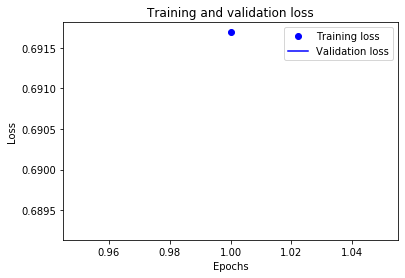

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Text(0.5, 1.0, 'Training and validation accuracy')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Accuracy')

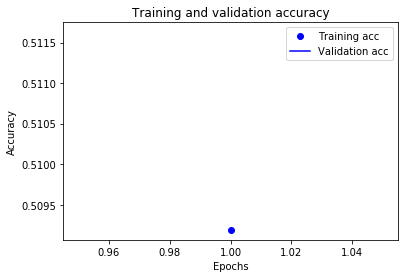

In [12]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()